# Comparing tree-based and deep learning methods
- Compare performance of XGBoost and MLP models.

In [1]:
import os
import pandas as pd 
import glob
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, f1_score
from xgboost import XGBRegressor, XGBClassifier
import json 
import matplotlib.pyplot as plt
from cmcrameri import cm as cmap_cm
from math import ceil
import sys 
sys.path.append("../..")
from zeobind.src.utils.utils import setup_mpl
setup_mpl()
import warnings
warnings.filterwarnings("ignore")

# Utility functions

In [2]:
cm = 1/2.54  # centimeters in inches

def save_mpl_fig(fig, basename, ending='.pdf', dpi=300):
    fig.savefig(basename + ending, bbox_inches='tight', dpi=dpi)

def format_axs(
    axs,
    xtick_size,
    ytick_size,
    spines_width,
    xlabel,
    ylabel,
    xlabel_size,
    ylabel_size,
    limits=None,
    tick_width=2, 
    tick_size=6, 
    bold_axs=False,
    xticks=None,
    yticks=None,
):
    
    # Set tick labels
    if xticks is not None:
        axs.set_xticks(xticks)
    if yticks is not None:
        axs.set_yticks(yticks)

    axs.tick_params(axis="x", which="major", labelsize=xtick_size)
    axs.tick_params(axis="y", which="major", labelsize=ytick_size)
    axs.xaxis.set_tick_params(width=tick_width, size=tick_size)
    axs.yaxis.set_tick_params(width=tick_width, size=tick_size)

    # axs.tick_params(axis='both', which='minor="something", labelsize=8)
    for axis in ["top", "bottom", "left", "right"]:
        axs.spines[axis].set_linewidth(spines_width)

    axs.set_xlabel(xlabel, fontsize=xlabel_size)
    axs.set_ylabel(ylabel, fontsize=ylabel_size)
    
    if not limits:
        return axs
    if "x" in limits.keys():
        axs.set_xlim(limits["x"])
    if "y" in limits.keys():
        axs.set_ylim(limits["y"])
    
    return axs

def get_cb(fig, sc, axs, label, ticks=None, linewidth=2, tickwidth=2, labelsize=18, labelpad=20):
    '''Get colorbar'''
    cb = fig.colorbar(sc, ax=axs)
    cb.set_label(label, fontsize=labelsize)
    cb.outline.set_linewidth(linewidth)
    if ticks is not None:
        cb.set_ticks(ticks)
    cb.ax.tick_params(width=tickwidth)
    cb.ax.tick_params(labelsize=labelsize)
    # pad
    cb.ax.xaxis.labelpad = labelpad
    return cb

def get_legend(
    fig,
    bbox_to_anchor=(0.5, 1.1),
    fontsize=15,
    loc="upper center",
    ncol=2,
    axs=None,
    format_handles=False,
    legend_colors=None,
    linewidth=2,
    edgecolor="k",
    put_where="fig",
):
    '''Get legend.'''
    positions = {"fig": fig, "axs": axs}
    legend = positions[put_where].legend(
        fontsize=fontsize,
        loc=loc,
        bbox_to_anchor=bbox_to_anchor,
        ncol=ncol,
        frameon=False,
    )

    if format_handles:
        for idx, handle in enumerate(legend.legendHandles):
            handle.set_color(legend_colors[idx])
            handle.set_linewidth(linewidth)
            handle.set_edgecolor(edgecolor)

    return legend
    
def get_color_values(num_colors, c="viridis"):
    '''Get a list of color values from a colormap'''
    cmap = plt.cm.get_cmap(c)
    color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
    return color_values

def draw_parity(axs, xlimits, ylimits, lw=1):
    '''Draw a parity line on a plot'''
    limits = [min(xlimits[0], ylimits[0]), max(xlimits[1], ylimits[1])]
    axs.plot(limits, limits, "k--", lw=lw)
    return axs

def get_gridsize(limits, hex_length):
    """Given the length of the x and y axis, as well as length of the hexagon, return the appropriate gridsize input."""
    ny = ceil( (limits['y'][1] - limits['y'][0]) / hex_length)
    nx = ceil(np.sqrt(3) * ny)
    return (nx, ny)

# Set up 
- The validation set used for assessment throughout this notebook contains both binding (B) and non-binding (NB) pairs.

In [3]:
op_dir = "../../data/runs/xgb"
os.listdir(op_dir) 

['energy', 'binary']

In [4]:
data_dir = "../../data/"

In [5]:
# common 

# get feature column names
with open("../src/configs/osda_v1_phys.json", "r") as f:
    o_X_cols = json.load(f).keys()
with open("../src/configs/zeolite_v1_phys_short.json", "r") as f:
    z_X_cols = json.load(f).keys()

# read prior files to make X. Also for sampling background dataset with
opriors = pd.read_pickle(f"{data_dir}/datasets/training_data/osda_priors_0.pkl")
zpriors = pd.read_pickle(f"{data_dir}/datasets/training_data/zeolite_priors_0.pkl")

# split into train, val and test 
split_dir = f"{data_dir}/datasets/training_data/splits/1/"
smiles_train = np.load(f"{split_dir}/smiles_train.npy")
smiles_val = np.load(f"{split_dir}/smiles_val.npy")
smiles_test = np.load(f"{split_dir}/smiles_test.npy")

# read truth to get index to make X
truth = pd.read_csv(f"{data_dir}/datasets/training_data/training_data.csv")
true_labels = truth[truth['SMILES'].isin(smiles_val)]
true_labels = true_labels.set_index(['SMILES', 'Zeolite'])

# make X
o = opriors.loc[truth['SMILES'].values][o_X_cols]
z = zpriors.loc[truth['Zeolite'].values][z_X_cols]

o = o.reset_index().rename(columns={'index': 'SMILES'})
z = z.reset_index().rename(columns={'index': 'Zeolite'})

X = pd.concat([o, z], axis=1)
X = X.set_index(['SMILES', 'Zeolite'])

# XGB models

## XGB E model
- All 20 hyperparameter tuning runs' models were saved. We load each of them and compute the validation set loss, and pick the one that gives us the lowest validation score.

In [7]:
# prepare input files and labels

e_run_dir = f"{op_dir}/energy/tune/"

# get X scaler

e_input_scaler = StandardScaler()
with open(f"{e_run_dir}/input_scaling.json", "r") as f:
    op_scaling_dict = json.load(f) 
e_input_scaler.mean_ = op_scaling_dict['mean']
e_input_scaler.var_ = op_scaling_dict['var']
e_input_scaler.scale_ = np.sqrt(e_input_scaler.var_)

X_scaled = e_input_scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

X_train_scaled = X_scaled[X_scaled.index.get_level_values('SMILES').isin(smiles_train)]
X_val_scaled = X_scaled[X_scaled.index.get_level_values('SMILES').isin(smiles_val)]
X_test_scaled = X_scaled[X_scaled.index.get_level_values('SMILES').isin(smiles_test)]

# load output scaler for energy

output_scaler = StandardScaler()
with open(f"{e_run_dir}/truth_scaling.json", "r") as f:
    op_scaling_dict = json.load(f) 
output_scaler.mean_ = op_scaling_dict['mean']
output_scaler.var_ = op_scaling_dict['var']
output_scaler.scale_ = np.sqrt(output_scaler.var_)

In [8]:
# compute metrics for each hp_run model

rmses = dict()

for hp_run in range(20):
    # load model

    model = XGBRegressor()
    f = f"{e_run_dir}/hp_tune_run_{hp_run}/model.json"
    model.load_model(f)

    # make and format predictions

    val_preds = model.predict(X_val_scaled)
    val_preds_rescaled = output_scaler.inverse_transform(val_preds.reshape(-1, 1))
    val_preds_rescaled = pd.DataFrame(val_preds_rescaled, index=X_val_scaled.index)

    # calculate

    batch_size = 256 
    batches = val_preds_rescaled.shape[0] // batch_size
    rmse_ls = []
    for i in range(batches):
        t = true_labels.iloc[i * batch_size : (i+1) * batch_size]['Binding (SiO2)']
        p = val_preds_rescaled.loc[t.index]
        rmse = np.sqrt(mean_squared_error(t, p))
        rmse_ls.append(rmse)
    rmses[hp_run] = np.mean(rmse_ls)

rmses = pd.DataFrame(rmses.items(), columns=['hp_run', 'rmse'])
rmses.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
hp_run,0.000000,1.000000,2.000000,3.000000,4.000000,5.00000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000
rmse,2.191541,1.395425,2.909817,2.022243,2.661183,3.45463,5.827897,2.129048,1.858812,2.808462,2.768361,1.621019,1.913272,2.866471,2.058862,2.441853,3.281134,2.237593,2.505711,3.098504


In [ ]:
# Find the E model that gives the best RMSE

r_e = rmses.set_index('hp_run').rmse.argmin()
print(r_e, rmses[rmses['hp_run'] == r_e]['rmse'].values[0])

1 1.3954247287583903


## XGB b model
- All 20 hyperparameter tuning runs' models were saved. We load each of them and compute the validation set loss, and pick the one that gives us the lowest validation score.
- Note that class 0 is `b=1` (binding) and class 1 is `b=0` (non-binding)

In [10]:
# prepare input files and labels

b_run_dir = f"{op_dir}/binary/tune/"

# get X scaler

b_input_scaler = StandardScaler()
with open(f"{b_run_dir}/input_scaling.json", "r") as f:
    op_scaling_dict = json.load(f) 
b_input_scaler.mean_ = op_scaling_dict['mean']
b_input_scaler.var_ = op_scaling_dict['var']
b_input_scaler.scale_ = np.sqrt(b_input_scaler.var_)

X_scaled = b_input_scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

X_train_scaled = X_scaled[X_scaled.index.get_level_values('SMILES').isin(smiles_train)]
X_val_scaled = X_scaled[X_scaled.index.get_level_values('SMILES').isin(smiles_val)]
X_test_scaled = X_scaled[X_scaled.index.get_level_values('SMILES').isin(smiles_test)]

In [11]:
# compute metrics for each hp_run model

binary_metrics = dict()

for hp_run in range(20):
    # load model

    model = XGBClassifier()
    f = f"{b_run_dir}/hp_tune_run_{hp_run}/model.json"
    model.load_model(f)

    # make and format predictions

    val_preds = model.predict(X_val_scaled)
    val_preds = pd.DataFrame(val_preds, index=X_val_scaled.index)

    # calculate

    batch_size = 256 
    batches = val_preds.shape[0] // batch_size
    metrics_ls = []
    for i in range(batches):
        t = true_labels.iloc[i * batch_size : (i+1) * batch_size]["b"]
        p = val_preds.loc[t.index][0] # TODO: check 0 or 1 - it is 0
        f1 = f1_score(t, p)
        metrics_ls.append(f1)
    binary_metrics[hp_run] = np.mean(metrics_ls)

binary_metrics = pd.DataFrame(binary_metrics.items(), columns=['hp_run', 'f1'])
binary_metrics.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
hp_run,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000
f1,0.915847,0.966611,0.969321,0.963486,0.969377,0.936619,0.968161,0.967319,0.967299,0.966223,0.956245,0.967361,0.966794,0.962389,0.966026,0.968998,0.967171,0.966345,0.967894,0.967661


In [ ]:
# find the best b model that gives the highest F1 score

r_b = binary_metrics.set_index('hp_run').f1.argmax()
print(r_b, binary_metrics[binary_metrics['hp_run'] == r_b]['f1'].values[0])

4 0.9693769254992518


## XGB BE 
- Pick the best model each from binary classification and energy regression tasks, and combine their predictions with `b*E`
- Note that binary and energy scalers are different because the former was scaled on B+NB training set, and the latter was scaled on B-only training set

In [13]:
print(f"Best binary hp run: {r_b}, energy hp run: {r_e}")

# load models

b_model = XGBClassifier()
f = f"{b_run_dir}/hp_tune_run_{r_b}/model.json"
b_model.load_model(f)

e_model = XGBRegressor()
f = f"{e_run_dir}/hp_tune_run_{r_e}/model.json"
e_model.load_model(f)

# make and format predictions

b_X_scaled = b_input_scaler.transform(X)
b_X_scaled = pd.DataFrame(b_X_scaled, index=X.index, columns=X.columns)
b_X_val_scaled = b_X_scaled[b_X_scaled.index.get_level_values('SMILES').isin(smiles_val)]
b_val_preds = b_model.predict(b_X_val_scaled)
b_val_preds = pd.DataFrame(b_val_preds, index=b_X_val_scaled.index)

e_X_scaled = e_input_scaler.transform(X)
e_X_scaled = pd.DataFrame(e_X_scaled, index=X.index, columns=X.columns)
e_X_val_scaled = e_X_scaled[e_X_scaled.index.get_level_values('SMILES').isin(smiles_val)]
e_X_val_scaled = pd.DataFrame(e_X_val_scaled, index=e_X_val_scaled.index, columns=e_X_val_scaled.columns)
e_val_preds = e_model.predict(e_X_val_scaled)

e_val_preds_rescaled = output_scaler.inverse_transform(e_val_preds.reshape(-1, 1))
e_val_preds_rescaled = pd.DataFrame(e_val_preds_rescaled, index=e_X_val_scaled.index)

# combine binary and energy into BE 

val_preds = pd.concat([b_val_preds, e_val_preds_rescaled], axis=1)
val_preds.columns = ["nb", "b", "E"]
val_preds["BE"] = val_preds["nb"] * val_preds["E"]

Best binary hp run: 4, energy hp run: 1


In [14]:
# RMSE for BE

rmse_ls = [] 
batch_size = 256 
batches = val_preds.shape[0] // batch_size
rmse_ls = []

for i in range(batches):
    t = true_labels.iloc[i * batch_size : (i+1) * batch_size]["Binding (SiO2)"]
    p = val_preds.loc[t.index]["BE"]
    rmse = np.sqrt(mean_squared_error(t, p))
    rmse_ls.append(rmse)

rmse = np.mean(rmse_ls)
print(f"BE RMSE on validation set: {rmse}")

BE RMSE on validation set: 1.0878835659673376


## Parity plots

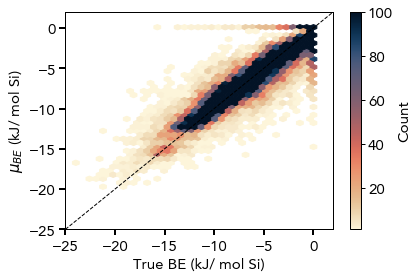

In [17]:
# parity for BE

figsize = np.array((13, 10)) * cm
limits = dict(x=(-25, 2), y=(-25, 2))
xticks = range(-25, 6, 5)
yticks = range(-25, 6, 5)
vmin = 1
vmax = 100

fig, axs = plt.subplots()

x = true_labels["Binding (SiO2)"]
y = val_preds.loc[x.index]['BE']
data_limits = dict(x=(min(x), max(x)), y=(min(y), max(y)))
gridsize = get_gridsize(data_limits, 1)
kwargs = dict(mincnt=1, cmap=cmap_cm.lipari.reversed(), vmin=vmin, vmax=vmax, gridsize=gridsize)

sc = axs.hexbin(x, y, **kwargs)
axs = format_axs(axs, 15, 15, 1, "True BE (kJ/ mol Si)", "$\mu_{BE}$ (kJ/ mol Si)", 15, 15, limits=limits, xticks=xticks, yticks=yticks)
cb = get_cb(fig, sc, axs, "Count", ticks=range(0, 101, 20), linewidth=1, tickwidth=1, labelsize=15, labelpad=5)
axs = draw_parity(axs, limits['x'], limits['y']);

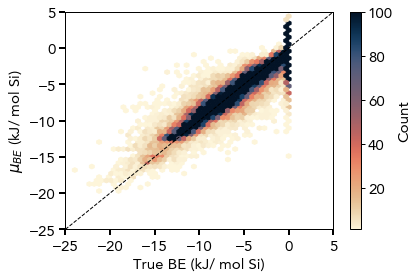

In [18]:
# Parity for E 

figsize = np.array((13, 10)) * cm
limits = dict(x=(-25, 5), y=(-25, 5))
xticks = range(-25, 6, 5)
yticks = range(-25, 6, 5)
vmin = 1
vmax = 100

fig, axs = plt.subplots()

x = true_labels["Binding (SiO2)"]
y = val_preds.loc[x.index]['E']
data_limits = dict(x=(min(x), max(x)), y=(min(y), max(y)))
gridsize = get_gridsize(data_limits, 1)
kwargs = dict(mincnt=1, cmap=cmap_cm.lipari.reversed(), vmin=vmin, vmax=vmax, gridsize=gridsize)

sc = axs.hexbin(x, y, **kwargs)
axs = format_axs(axs, 15, 15, 1, "True BE (kJ/ mol Si)", "$\mu_{BE}$ (kJ/ mol Si)", 15, 15, limits=limits, xticks=xticks, yticks=yticks)
cb = get_cb(fig, sc, axs, "Count", ticks=range(0, 101, 20), linewidth=1, tickwidth=1, labelsize=15, labelpad=5)
axs = draw_parity(axs, limits['x'], limits['y']);

# MLP models
- Only the best model was saved. Formatting the data and loading the model uses a lot of code, so we use the `predict.sh` script and read the predictions instead
- We use the model from the ensemble that was trained on the same train/val/test split as the xgboost models (split 1)

In [19]:
# read predictions 
mlp_pred_dir = "../../data/predictions/training_data/"

mlp_e_preds = pd.read_csv(f"{mlp_pred_dir}/energy/osda_priors_0_zeolite_priors_0_preds.csv", index_col=0)
mlp_b_preds = pd.read_csv(f"{mlp_pred_dir}/binary_likelihood//osda_priors_0_zeolite_priors_0_preds.csv", index_col=0)

In [20]:
# keep the columns with the same splits as the xgboost models
mlp_e_preds = mlp_e_preds[["SMILES", "Zeolite", "Binding (SiO2) (0)"]]
mlp_b_preds = mlp_b_preds[["SMILES", "Zeolite", "b (0)", "nb (0)"]]

# extract the validation set 
mlp_e_preds_val = mlp_e_preds[mlp_e_preds['SMILES'].isin(smiles_val)]
mlp_e_preds_val = mlp_e_preds_val.set_index(['SMILES', 'Zeolite'])

mlp_b_preds_val = mlp_b_preds[mlp_b_preds['SMILES'].isin(smiles_val)]
mlp_b_preds_val = mlp_b_preds.set_index(['SMILES', 'Zeolite'])

# combine into one df and format

mlp_preds_val = pd.concat([mlp_e_preds_val, mlp_b_preds_val], axis=1)
mlp_preds_val["binding"] = mlp_preds_val[["b (0)", "nb (0)"]].T.idxmax().values
mlp_preds_val["binding"] = mlp_preds_val["binding"].apply(lambda x: 1 if x == "b (0)" else 0)
mlp_preds_val["BE"] = mlp_preds_val["binding"] * mlp_preds_val["Binding (SiO2) (0)"]

## MLP E model

In [21]:
# E RMSE 

batch_size = 256 
batches = true_labels.shape[0] // batch_size
rmse_ls = []
for i in range(batches):
    t = true_labels.iloc[i * batch_size : (i+1) * batch_size]["Binding (SiO2)"]
    p = mlp_preds_val.loc[t.index]["Binding (SiO2) (0)"]
    rmse = np.sqrt(mean_squared_error(t, p))
    rmse_ls.append(rmse)

print(f"MLP E RMSE: {np.mean(rmse_ls)}")

MLP E RMSE: 1.2285461520642946


## MLP b model

In [22]:
# b F1 score 

batch_size = 256 
batches = true_labels.shape[0] // batch_size
metrics_ls = []
for i in range(batches):
    t = true_labels.iloc[i * batch_size : (i+1) * batch_size]["b"]
    p = mlp_preds_val.loc[t.index]["binding"]
    rmse = f1_score (t, p)
    metrics_ls.append(rmse)

print(f"MLP b F1 score: {np.mean(metrics_ls)}")

MLP b F1 score: 0.9710859894302091


## MLP BE

In [23]:
# BE RMSE

batch_size = 256 
batches = true_labels.shape[0] // batch_size
rmse_ls = []
for i in range(batches):
    t = true_labels.iloc[i * batch_size : (i+1) * batch_size]["Binding (SiO2)"]
    p = mlp_preds_val.loc[t.index]["BE"]
    rmse = np.sqrt(mean_squared_error(t, p))
    rmse_ls.append(rmse)

print(f"MLP BE RMSE: {np.mean(rmse_ls)}")

MLP BE RMSE: 0.988891272254095


## Parity plots

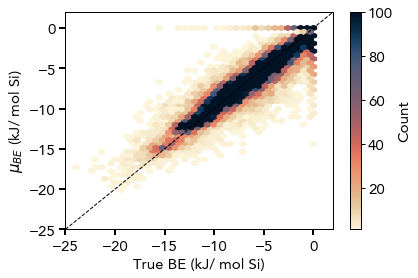

In [24]:
# parity for BE

figsize = np.array((13, 10)) * cm
limits = dict(x=(-25, 2), y=(-25, 2))
xticks = range(-25, 6, 5)
yticks = range(-25, 6, 5)
vmin = 1
vmax = 100

fig, axs = plt.subplots()

x = true_labels["Binding (SiO2)"]
y = mlp_preds_val.loc[x.index]['BE']
data_limits = dict(x=(min(x), max(x)), y=(min(y), max(y)))
gridsize = get_gridsize(data_limits, 1)
kwargs = dict(mincnt=1, cmap=cmap_cm.lipari.reversed(), vmin=vmin, vmax=vmax, gridsize=gridsize)

sc = axs.hexbin(x, y, **kwargs)
axs = format_axs(axs, 15, 15, 1, "True BE (kJ/ mol Si)", "$\mu_{BE}$ (kJ/ mol Si)", 15, 15, limits=limits, xticks=xticks, yticks=yticks)
cb = get_cb(fig, sc, axs, "Count", ticks=range(0, 101, 20), linewidth=1, tickwidth=1, labelsize=15, labelpad=5)
axs = draw_parity(axs, limits['x'], limits['y']);

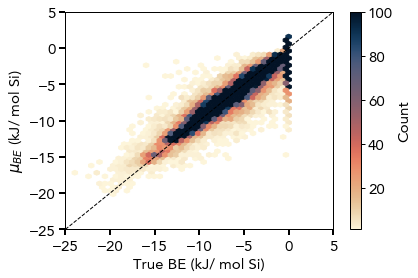

In [25]:
# Parity for E 

figsize = np.array((13, 10)) * cm
limits = dict(x=(-25, 5), y=(-25, 5))
xticks = range(-25, 6, 5)
yticks = range(-25, 6, 5)
vmin = 1
vmax = 100

fig, axs = plt.subplots()

x = true_labels["Binding (SiO2)"]
y = mlp_preds_val.loc[x.index]['Binding (SiO2) (0)']
data_limits = dict(x=(min(x), max(x)), y=(min(y), max(y)))
gridsize = get_gridsize(data_limits, 1)
kwargs = dict(mincnt=1, cmap=cmap_cm.lipari.reversed(), vmin=vmin, vmax=vmax, gridsize=gridsize)

sc = axs.hexbin(x, y, **kwargs)
axs = format_axs(axs, 15, 15, 1, "True BE (kJ/ mol Si)", "$\mu_{BE}$ (kJ/ mol Si)", 15, 15, limits=limits, xticks=xticks, yticks=yticks)
cb = get_cb(fig, sc, axs, "Count", ticks=range(0, 101, 20), linewidth=1, tickwidth=1, labelsize=15, labelpad=5)
axs = draw_parity(axs, limits['x'], limits['y']);

# Performance on held out sets
- Compare the performance of XGBoost and MLP models on held out sets of hypothetical monoquatenary and diquaternary molecules

In [ ]:
# Read XGB predictions

xgb_pred_dir = f"{data_dir}/predictions/xgb/"
xgb_pred_heldout_dir = f"{xgb_pred_dir}/heldout_hyp_mols/"
xgb_pred_train_dir = f"{xgb_pred_dir}/training_data/"

# read predictions
pred_file = "osda_priors_0_zeolite_priors_0_preds.csv"
xgb_b_train_preds = pd.read_csv(f"{xgb_pred_train_dir}/binary_classification/{pred_file}", index_col=0)
xgb_e_train_preds = pd.read_csv(f"{xgb_pred_train_dir}/energy_regression/{pred_file}", index_col=0)

xgb_b_heldout_preds = pd.read_csv(f"{xgb_pred_heldout_dir}/binary_classification/{pred_file}", index_col=0)
xgb_e_heldout_preds = pd.read_csv(f"{xgb_pred_heldout_dir}/energy_regression/{pred_file}", index_col=0)

# combine into one DF 
xgb_train_preds = pd.concat([
    xgb_b_train_preds.set_index(["Zeolite", "SMILES"]),
    xgb_e_train_preds.set_index(["Zeolite", "SMILES"])
], axis=1)

xgb_heldout_preds = pd.concat([
    xgb_b_heldout_preds.set_index(["Zeolite", "SMILES"]),
    xgb_e_heldout_preds.set_index(["Zeolite", "SMILES"])
], axis=1)

xgb_preds = pd.concat([xgb_train_preds, xgb_heldout_preds])
xgb_preds["BE"] = xgb_preds["binding"] * xgb_preds["Binding (SiO2)"]

In [ ]:
# Read MLP predictions 

mlp_pred_dir = f"{data_dir}/predictions/"
mlp_pred_heldout_dir = f"{mlp_pred_dir}/heldout_hyp_mols/formatted_be"
mlp_pred_train_dir = f"{mlp_pred_dir}/training_data/formatted_be"

# read predictions
mlp_be_train_preds = [pd.read_csv(f, index_col=0) for f in glob.glob(f"{mlp_pred_train_dir}/*_mean_*.csv")]
mlp_be_heldout_preds = [pd.read_csv(f, index_col=0) for f in glob.glob(f"{mlp_pred_heldout_dir}/*_mean_*.csv")]

# combine into one DF 
mlp_be_train_preds = pd.concat(mlp_be_train_preds)
mlp_be_heldout_preds = pd.concat(mlp_be_heldout_preds)
mlp_preds = pd.concat([mlp_be_train_preds, mlp_be_heldout_preds])

# format to be consistent with XGB
mlp_preds = mlp_preds.unstack()
mlp_preds = mlp_preds.reset_index()
mlp_preds.columns = ["Zeolite", "SMILES", "BE"]
mlp_preds = mlp_preds.set_index(["Zeolite", "SMILES"])

In [ ]:
all_preds = {
    "xgb": xgb_preds,
    "mlp": mlp_preds
}

In [ ]:
# read heldout dataset truth

heldout_truth = pd.read_csv(f"{data_dir}/datasets/heldout_hyp_mols/heldout_data.csv", index_col=0)
heldout_truth = heldout_truth.set_index(["Zeolite", "SMILES"])
heldout_truth["charge"] = heldout_truth.index.get_level_values("SMILES").map(lambda x: x.count("+]") - x.count("-]"))

In [ ]:
for model_type, preds in all_preds.items():
    for charge in [1, 2]:
        rmse_ls = [] 
        batch_size = 256 
        batches = heldout_truth[heldout_truth.charge == charge].shape[0] // batch_size
        rmse_ls = []

        for i in range(batches):
            t = heldout_truth[heldout_truth.charge == charge].iloc[i * batch_size : (i+1) * batch_size]['Binding (SiO2)']
            p = preds.loc[t.index]['BE']
            rmse = np.sqrt(mean_squared_error(t, p))
            rmse_ls.append(rmse)

        rmse = np.mean(rmse_ls)
        print(f"{model_type} BE RMSE on heldout set with charge +{charge}: {rmse}")

xgb BE RMSE on heldout set with charge +1: 4.63601986288674
xgb BE RMSE on heldout set with charge +2: 3.855824884583879
mlp BE RMSE on heldout set with charge +1: 1.0470854167060257
mlp BE RMSE on heldout set with charge +2: 1.6682088773724912
